In [2]:
import tensorflow as tf
import os
import glob
import numpy as np
import csv
import random
from scipy.misc import imread,imresize

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from cub_fewshot.image_utils import *

In [12]:
class FewshotBirdsDataGenerator(object):

        def __init__(self, batch_size=10, episode_length=10, episode_width=5, image_dim=(244, 244, 3)):
            self.splits = {
                'train' : '/home/jason/deep-parts-model/src/cub_fewshot/splits/train_img_path_label_size_bbox_parts_split.txt',
                'test'  : '/home/jason/deep-parts-model/src/cub_fewshot/splits/test_img_path_label_size_bbox_parts_split.txt',
                'val'   : '/home/jason/deep-parts-model/src/cub_fewshot/splits/val_img_path_label_size_bbox_parts_split.txt'
            }
            self.batch_size = batch_size
            self.episode_length = episode_length
            self.episode_width = episode_width
            self.image_dim = image_dim
            self.num_classes = 200
            self._cache = {}
            self._load_data()

        def _load_data(self):
            self.train_data = self._data_dict_for_split(self.splits['train'])
            print('finished train')
            self.test_data  = self._data_dict_for_split(self.splits['test'])
            print('finished test')
            self.val_data   = self._data_dict_for_split(self.splits['val'])
            print('finished val')

        def sample_episode_batch(self, data):
            """Generates a random batch for training or validation.

            Structures each element of the batch as an 'episode'.
            Each episode contains episode_length examples and
            episode_width distinct labels.

            Args:
              data: A dictionary mapping label to list of examples.
              episode_length: Number of examples in each episode.
              episode_width: Distinct number of labels in each episode.
              batch_size: Batch size (number of episodes).

            Returns:
              A tuple (x, y) where x is a list of batches of examples
              with size episode_length and y is a list of batches of labels.
            """
            episodes_x = [[] for _ in xrange(self.episode_length)]
            episodes_y = [[] for _ in xrange(self.episode_length)]
            assert len(data) >= self.episode_width
            keys = data.keys()
            for b in xrange(self.batch_size):
                episode_labels = random.sample(keys, self.episode_width)
                remainder = self.episode_length % self.episode_width
                remainders = [0] * (self.episode_width - remainder) + [1] * remainder
                episode_x = [
                  random.sample(data[lab],
                                r + (self.episode_length - remainder) // self.episode_width)
                  for lab, r in zip(episode_labels, remainders)]
                episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
                             for i, xx in enumerate(episode_x)], [])
                random.shuffle(episode)
                # Arrange episode so that each distinct label is seen before moving to
                # 2nd showing
                episode.sort(key=lambda elem: elem[2])
                assert len(episode) == self.episode_length
                for i in xrange(self.episode_length):
                    episodes_x[i].append(episode[i][0])
                    episodes_y[i].append(episode[i][1] + b * self.episode_width)
            episodes_x = self._get_examples_for_image_configs(episodes_x) 
            episodes_y = [np.array(yy).astype('int32') for yy in episodes_y]
            return (episodes_x, episodes_y)

        def _data_dict_for_split(self, split, mode='test'):
            label_to_examples_dict = {}
            with open(split, 'r') as f:
                lines = f.readlines()
            for line in lines:
                # get x, y, bbox, and parts from line
                line = line.strip()
                line = line.split(' ')
                image_path, y, size, bbox, parts = line[0], line[1], line[2:4], line[4:8], line[8:]
                size = [int(s) for s in size]
                y, bbox, parts = int(y), [float(b) for b in bbox], [float(p) for p in parts]
                parts_x, parts_y = parts[0::2], parts[1::2]
                if y not in label_to_examples_dict:
                    label_to_examples_dict[y] = []
                # example is going to be x, p1, p2
                # instead of storing this store args
                label_to_examples_dict[y].append((image_path, size, bbox, parts_x, parts_y, mode))
            return label_to_examples_dict

        def _get_examples_for_image_configs(self, configs):
            '''
            parses the configs of dim: self.batch_size X self.episode_length X 1
            and returns a np.array of image_and_parts of dim: self.batch_size X 3 X self.episode_length X self.image_dim
            '''
            H, W, C = self.image_dim:
            examples = [[None] * self.batch_size] * self.episode_length
            for i, config_batch in enumerate(configs):
                for j, c in enumerate(config_batch):
                    image_path, size, bbox, parts_x, parts_y, mode = c
                    if image_path in self._cache:
                        examples[i][j] = self._cache[image_path]
                    else:
                        image_and_parts = self._parser(image_path, size, bbox, parts_x, parts_y, mode)
                        examples[i][j] = image_and_parts
                        self._cache[image_path] = image_and_parts
            return [np.array(xx).astype('uint8') for xx in examples]

        def _parser(self, image_path, size, bbox, parts_x, parts_y, mode='test'):
            # decode the image
            new_height, new_width, new_channels = self.image_dim
            image = imread(image_path) # imread(image_path)
            # black and white image
            if len(image.shape) == 2 and new_channels == 3:
                # duplicat channels 3 times
                image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
                
            # get height and width of image to normalize the bounding box and part locations
            height, width = size
            # normalize bbox
            x, y, w, h = [int(b) for b in bbox]
            # extract parts
            breast_x, breast_y = int(parts_x[3]), int(parts_y[3])
            crown_x, crown_y = int(parts_x[4]), int(parts_y[4])
            nape_x, nape_y = int(parts_x[9]), int(parts_y[9])
            tail_x, tail_y = int(parts_x[13]), int(parts_y[13])
            leg_x, leg_y = int(parts_x[7]), int(parts_y[7])
            beak_x, beak_y = int(parts_x[1]), int(parts_y[1])
            try:
                # get crop for body
                bxmin, bxmax = min(tail_x, beak_x), max(tail_x, beak_x)
                bymin, bymax = min(leg_y, nape_y, breast_y), max(leg_y, nape_y, breast_y)
                bymin, bymax, bxmin, bxmax = int(bymin), int(bymax), int(bxmin), int(bxmax)
                body_crop = image[bymin:bymax, bxmin:bxmax, :]
                body_crop = imresize(body_crop, size=(new_height, new_width))
                # get crop for head
                x_len = abs(beak_x - nape_x)
                y_len = abs(crown_x - nape_x)
                bymin, bymax = min(nape_y, crown_y), max(nape_y, crown_y) + y_len
                bxmin, bxmax = max(crown_x - x_len, 0), min(crown_x + x_len, width)
                bymin, bymax, bxmin, bxmax = int(bymin), int(bymax), int(bxmin), int(bxmax)
                head_crop = image[bymin:bymax, bxmin:bxmax, :]
                head_crop = imresize(head_crop, size=(new_height, new_width))
            # one of the parts used in the above calculation was missing
            except:
                image_crop = image[y:y+h, x:x+w, :]
                head_crop = image_crop[int(h/2):, :, :] # top half of crop 
                head_crop = imresize(head_crop, size=(new_height, new_width))
                body_crop = image_crop[0:int(h/2), :, :] # bottom half of crop
                body_crop = imresize(body_crop, size=(new_height, new_width))
                # plot
                #f, ax = plt.subplots(3, figsize=(4, 4))
                #ax[0].imshow(image)
                #ax[1].imshow(head_crop)
                #ax[2].imshow(body_crop)
                #plt.show()
            if mode == 'train':
                # resize the image to 256xS where S is max(largest-image-side, 244)
                # TODO: this seems semi random not sure why STN used this
                clipped_height, clipped_width = max(height, 244), max(width, 244)
                if height > width:
                    image = imresize(image, size=(clipped_height, 256))
                else:
                    image = imresize(image, size=(256, clipped_width))
                image = random_crop(image, new_height)
                image = horizontal_flip(image)
            else:
                image = central_crop(image, central_fraction=0.875)
                image = imresize(image, size=(new_height, new_width, new_channels))
            image_and_parts = np.stack([image, body_crop, head_crop], axis=0)
            return image_and_parts

finished train
finished test
finished val
('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/162.Canada_Warbler/Canada_Warbler_0113_162403.jpg')
('image shape:', (334, 500, 3))


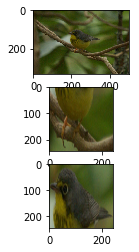

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/116.Chipping_Sparrow/Chipping_Sparrow_0026_109010.jpg')
('image shape:', (333, 500, 3))


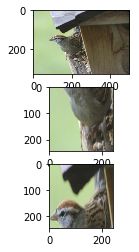

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/178.Swainson_Warbler/Swainson_Warbler_0008_794886.jpg')
('image shape:', (500, 418, 3))


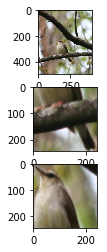

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/062.Herring_Gull/Herring_Gull_0051_46276.jpg')
('image shape:', (345, 500, 3))


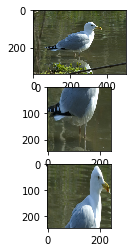

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/057.Rose_breasted_Grosbeak/Rose_Breasted_Grosbeak_0026_39191.jpg')
('image shape:', (333, 500, 3))


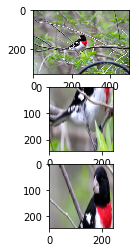

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/015.Lazuli_Bunting/Lazuli_Bunting_0052_14618.jpg')
('image shape:', (230, 500, 3))


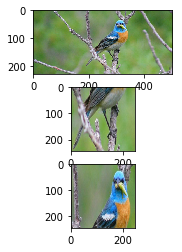

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/184.Louisiana_Waterthrush/Louisiana_Waterthrush_0081_795283.jpg')
('image shape:', (360, 480, 3))


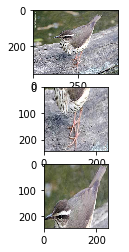

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0010_161169.jpg')
('image shape:', (333, 500, 3))


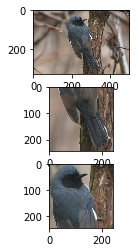

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0061_21967.jpg')
('image shape:', (334, 500, 3))


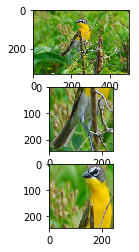

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/171.Myrtle_Warbler/Myrtle_Warbler_0015_166713.jpg')
('image shape:', (441, 500, 3))


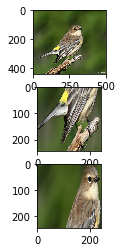

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/198.Rock_Wren/Rock_Wren_0100_189426.jpg')
('image shape:', (325, 500, 3))


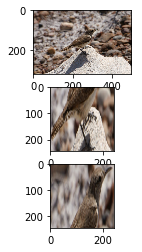

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/168.Kentucky_Warbler/Kentucky_Warbler_0014_165336.jpg')
('image shape:', (333, 500, 3))


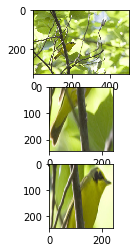

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/110.Geococcyx/Geococcyx_0056_104142.jpg')
('image shape:', (344, 500, 3))


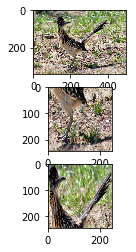

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg')
('image shape:', (305, 500, 3))


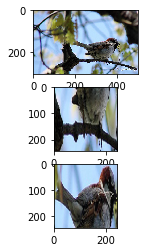

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/069.Rufous_Hummingbird/Rufous_Hummingbird_0052_59581.jpg')
('image shape:', (333, 500, 3))


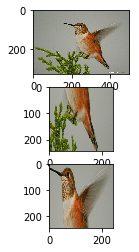

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/100.Brown_Pelican/Brown_Pelican_0125_93461.jpg')
('image shape:', (500, 336, 3))


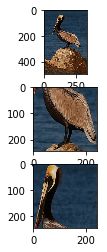

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0034_168185.jpg')
('image shape:', (333, 500, 3))


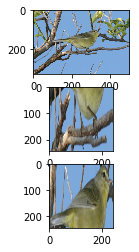

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/120.Fox_Sparrow/Fox_Sparrow_0121_114886.jpg')
('image shape:', (500, 327, 3))


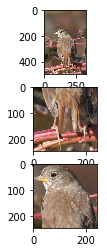

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/154.Red_eyed_Vireo/Red_Eyed_Vireo_0123_156780.jpg')
('image shape:', (333, 500, 3))


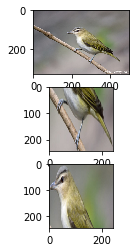

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/069.Rufous_Hummingbird/Rufous_Hummingbird_0014_59476.jpg')
('image shape:', (500, 333, 3))


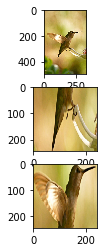

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/052.Pied_billed_Grebe/Pied_Billed_Grebe_0013_35882.jpg')
('image shape:', (284, 500, 3))


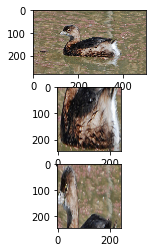

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/184.Louisiana_Waterthrush/Louisiana_Waterthrush_0029_795262.jpg')
('image shape:', (288, 311, 3))


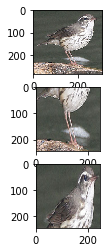

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/120.Fox_Sparrow/Fox_Sparrow_0123_114488.jpg')
('image shape:', (333, 500, 3))


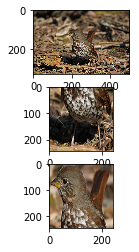

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0063_21783.jpg')
('image shape:', (398, 500, 3))


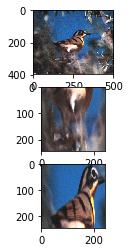

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/093.Clark_Nutcracker/Clark_Nutcracker_0087_84898.jpg')
('image shape:', (333, 500, 3))


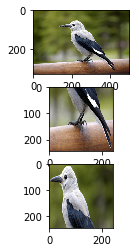

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/115.Brewer_Sparrow/Brewer_Sparrow_0022_107440.jpg')
('image shape:', (500, 405, 3))


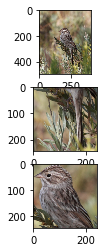

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/139.Scarlet_Tanager/Scarlet_Tanager_0068_137758.jpg')
('image shape:', (345, 500, 3))


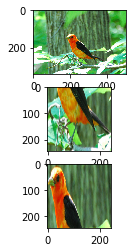

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/044.Frigatebird/Frigatebird_0121_42791.jpg')
('image shape:', (400, 500, 3))


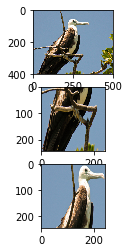

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0085_797260.jpg')
('image shape:', (418, 500, 3))


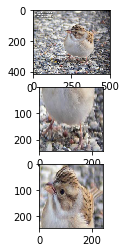

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/073.Blue_Jay/Blue_Jay_0036_61560.jpg')
('image shape:', (500, 404, 3))


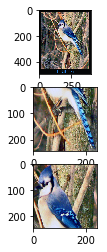

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/058.Pigeon_Guillemot/Pigeon_Guillemot_0108_40235.jpg')
('image shape:', (334, 500, 3))


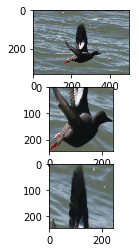

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/159.Black_and_white_Warbler/Black_And_White_Warbler_0074_160361.jpg')
('image shape:', (473, 500, 3))


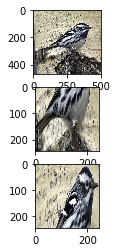

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0121_113182.jpg')
('image shape:', (332, 500, 3))


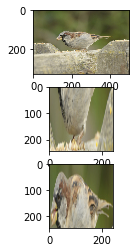

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/104.American_Pipit/American_Pipit_0109_99710.jpg')
('image shape:', (333, 500, 3))


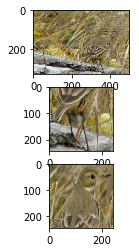

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/154.Red_eyed_Vireo/Red_Eyed_Vireo_0059_156974.jpg')
('image shape:', (381, 500, 3))


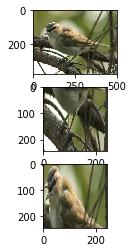

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0055_159740.jpg')
('image shape:', (333, 500, 3))


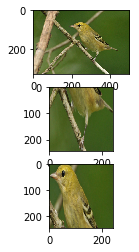

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/150.Sage_Thrasher/Sage_Thrasher_0096_155449.jpg')
('image shape:', (395, 500, 3))


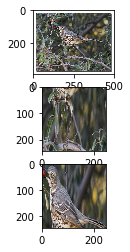

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/011.Rusty_Blackbird/Rusty_Blackbird_0016_6684.jpg')
('image shape:', (333, 500, 3))


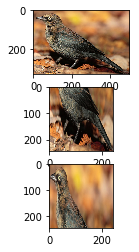

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/048.European_Goldfinch/European_Goldfinch_0076_33173.jpg')
('image shape:', (500, 357, 3))


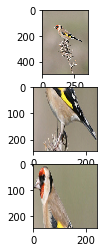

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/054.Blue_Grosbeak/Blue_Grosbeak_0009_36992.jpg')
('image shape:', (500, 462, 3))


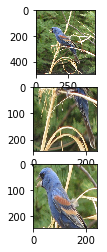

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/132.White_crowned_Sparrow/White_Crowned_Sparrow_0064_126467.jpg')
('image shape:', (500, 375, 3))


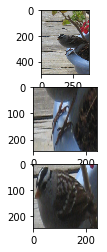

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0043_161438.jpg')
('image shape:', (333, 500, 3))


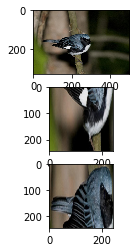

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/073.Blue_Jay/Blue_Jay_0066_61490.jpg')
('image shape:', (447, 500, 3))


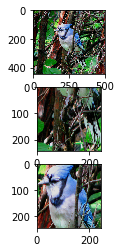

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/032.Mangrove_Cuckoo/Mangrove_Cuckoo_0035_794595.jpg')
('image shape:', (218, 220, 3))


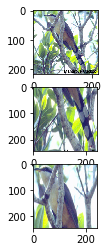

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/110.Geococcyx/Geococcyx_0079_104249.jpg')
('image shape:', (332, 500, 3))


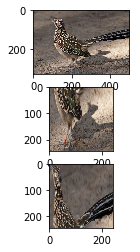

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/032.Mangrove_Cuckoo/Mangrove_Cuckoo_0027_26360.jpg')
('image shape:', (500, 334, 3))


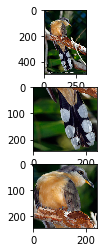

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/100.Brown_Pelican/Brown_Pelican_0071_94549.jpg')
('image shape:', (333, 500, 3))


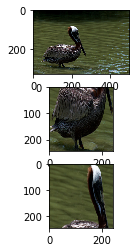

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/085.Horned_Lark/Horned_Lark_0033_74344.jpg')
('image shape:', (342, 500, 3))


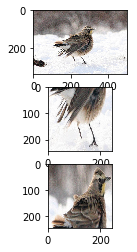

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/167.Hooded_Warbler/Hooded_Warbler_0058_164674.jpg')
('image shape:', (375, 500, 3))


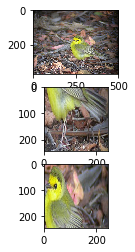

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/132.White_crowned_Sparrow/White_Crowned_Sparrow_0040_127313.jpg')
('image shape:', (400, 500, 3))


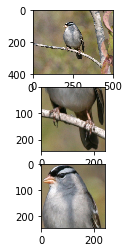

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/168.Kentucky_Warbler/Kentucky_Warbler_0080_165351.jpg')
('image shape:', (333, 500, 3))


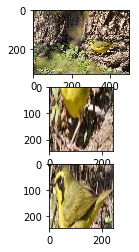

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0030_111387.jpg')
('image shape:', (489, 500, 3))


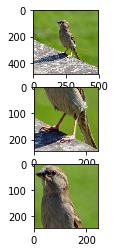

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/032.Mangrove_Cuckoo/Mangrove_Cuckoo_0046_794616.jpg')
('image shape:', (350, 350, 3))


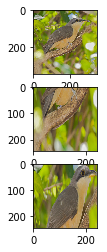

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/154.Red_eyed_Vireo/Red_Eyed_Vireo_0061_157202.jpg')
('image shape:', (500, 333, 3))


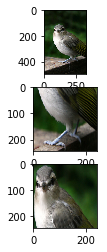

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/100.Brown_Pelican/Brown_Pelican_0007_94078.jpg')
('image shape:', (346, 500, 3))


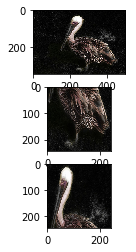

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/184.Louisiana_Waterthrush/Louisiana_Waterthrush_0016_795240.jpg')
('image shape:', (288, 396, 3))


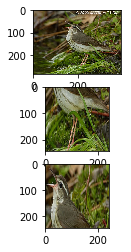

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/011.Rusty_Blackbird/Rusty_Blackbird_0032_6611.jpg')
('image shape:', (333, 500, 3))


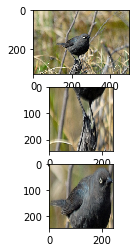

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0058_21864.jpg')
('image shape:', (333, 500, 3))


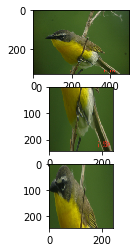

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/054.Blue_Grosbeak/Blue_Grosbeak_0022_37082.jpg')
('image shape:', (375, 500, 3))


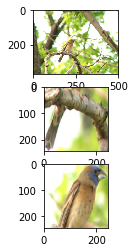

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/198.Rock_Wren/Rock_Wren_0113_189204.jpg')
('image shape:', (359, 500, 3))


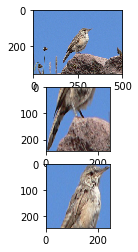

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/116.Chipping_Sparrow/Chipping_Sparrow_0045_109985.jpg')
('image shape:', (357, 500, 3))


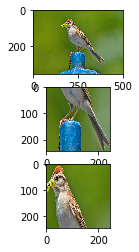

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/120.Fox_Sparrow/Fox_Sparrow_0081_115630.jpg')
('image shape:', (335, 500, 3))


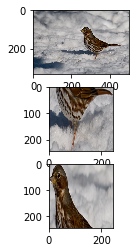

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0063_111460.jpg')
('image shape:', (333, 500, 3))


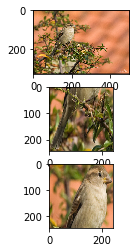

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/057.Rose_breasted_Grosbeak/Rose_Breasted_Grosbeak_0029_39434.jpg')
('image shape:', (375, 500, 3))


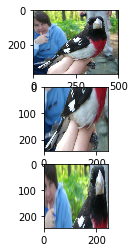

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/158.Bay_breasted_Warbler/Bay_Breasted_Warbler_0065_159722.jpg')
('image shape:', (417, 500, 3))


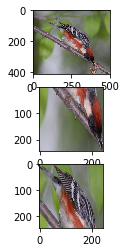

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0014_21970.jpg')
('image shape:', (347, 500, 3))


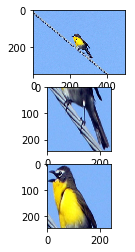

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/120.Fox_Sparrow/Fox_Sparrow_0039_114816.jpg')
('image shape:', (357, 500, 3))


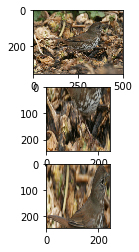

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/048.European_Goldfinch/European_Goldfinch_0093_794653.jpg')
('image shape:', (500, 357, 3))


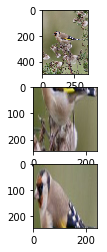

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/167.Hooded_Warbler/Hooded_Warbler_0078_165123.jpg')
('image shape:', (375, 500, 3))


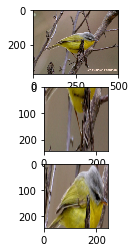

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/162.Canada_Warbler/Canada_Warbler_0074_162366.jpg')
('image shape:', (333, 500, 3))


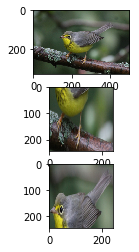

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/184.Louisiana_Waterthrush/Louisiana_Waterthrush_0094_795264.jpg')
('image shape:', (389, 500, 3))


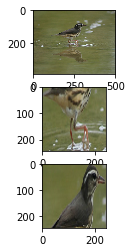

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/178.Swainson_Warbler/Swainson_Warbler_0013_794892.jpg')
('image shape:', (500, 375, 3))


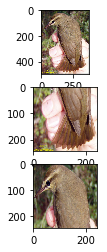

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/062.Herring_Gull/Herring_Gull_0049_46508.jpg')
('image shape:', (393, 500, 3))


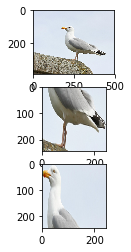

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/093.Clark_Nutcracker/Clark_Nutcracker_0067_85302.jpg')
('image shape:', (500, 333, 3))


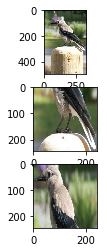

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/032.Mangrove_Cuckoo/Mangrove_Cuckoo_0051_794627.jpg')
('image shape:', (333, 500, 3))


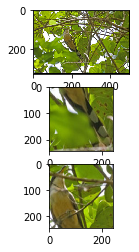

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0102_168189.jpg')
('image shape:', (351, 500, 3))


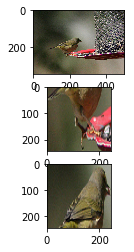

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0073_161558.jpg')
('image shape:', (337, 500, 3))


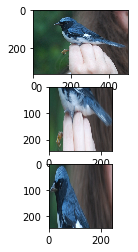

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0040_110717.jpg')
('image shape:', (318, 500, 3))


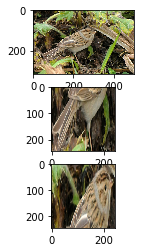

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/069.Rufous_Hummingbird/Rufous_Hummingbird_0027_59456.jpg')
('image shape:', (334, 500, 3))


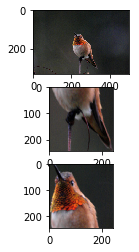

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/052.Pied_billed_Grebe/Pied_Billed_Grebe_0050_35530.jpg')
('image shape:', (335, 500, 3))


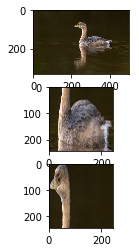

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0080_161681.jpg')
('image shape:', (500, 357, 3))


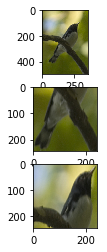

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/110.Geococcyx/Geococcyx_0105_104239.jpg')
('image shape:', (417, 500, 3))


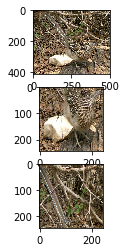

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0034_21955.jpg')
('image shape:', (500, 333, 3))


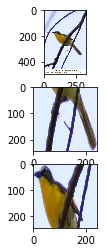

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/110.Geococcyx/Geococcyx_0038_104266.jpg')
('image shape:', (500, 377, 3))


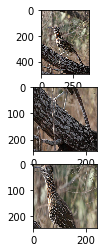

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/015.Lazuli_Bunting/Lazuli_Bunting_0010_14915.jpg')
('image shape:', (428, 500, 3))


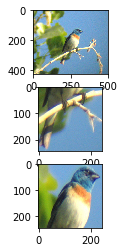

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/139.Scarlet_Tanager/Scarlet_Tanager_0025_138712.jpg')
('image shape:', (399, 500, 3))


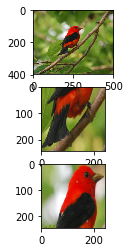

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/100.Brown_Pelican/Brown_Pelican_0110_93622.jpg')
('image shape:', (500, 320, 3))


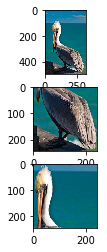

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/154.Red_eyed_Vireo/Red_Eyed_Vireo_0002_156470.jpg')
('image shape:', (399, 500, 3))


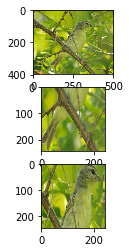

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/073.Blue_Jay/Blue_Jay_0089_61521.jpg')
('image shape:', (500, 480, 3))


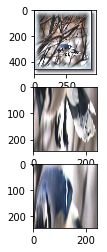

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/058.Pigeon_Guillemot/Pigeon_Guillemot_0030_40089.jpg')
('image shape:', (335, 500, 3))


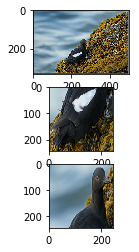

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/159.Black_and_white_Warbler/Black_And_White_Warbler_0106_160014.jpg')
('image shape:', (337, 500, 3))


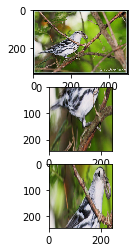

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/073.Blue_Jay/Blue_Jay_0056_61723.jpg')
('image shape:', (500, 400, 3))


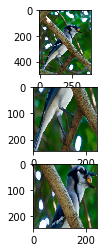

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/104.American_Pipit/American_Pipit_0111_99940.jpg')
('image shape:', (349, 500, 3))


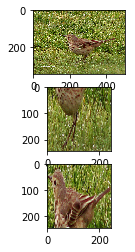

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/069.Rufous_Hummingbird/Rufous_Hummingbird_0120_59900.jpg')
('image shape:', (333, 500, 3))


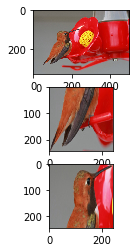

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/115.Brewer_Sparrow/Brewer_Sparrow_0070_796717.jpg')
('image shape:', (333, 500, 3))


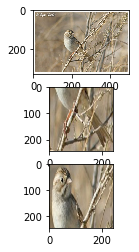

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/150.Sage_Thrasher/Sage_Thrasher_0097_155564.jpg')
('image shape:', (380, 500, 3))


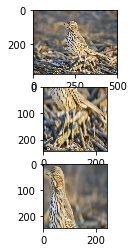

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/044.Frigatebird/Frigatebird_0050_43084.jpg')
('image shape:', (333, 500, 3))


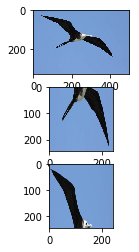

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/085.Horned_Lark/Horned_Lark_0139_74492.jpg')
('image shape:', (500, 386, 3))


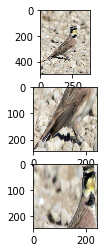

('image path:', '/dvmm-filer2/users/jason/datasets/CUB_200_2011/images/171.Myrtle_Warbler/Myrtle_Warbler_0043_166708.jpg')
('image shape:', (500, 464, 3))


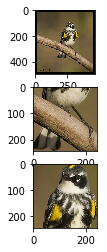

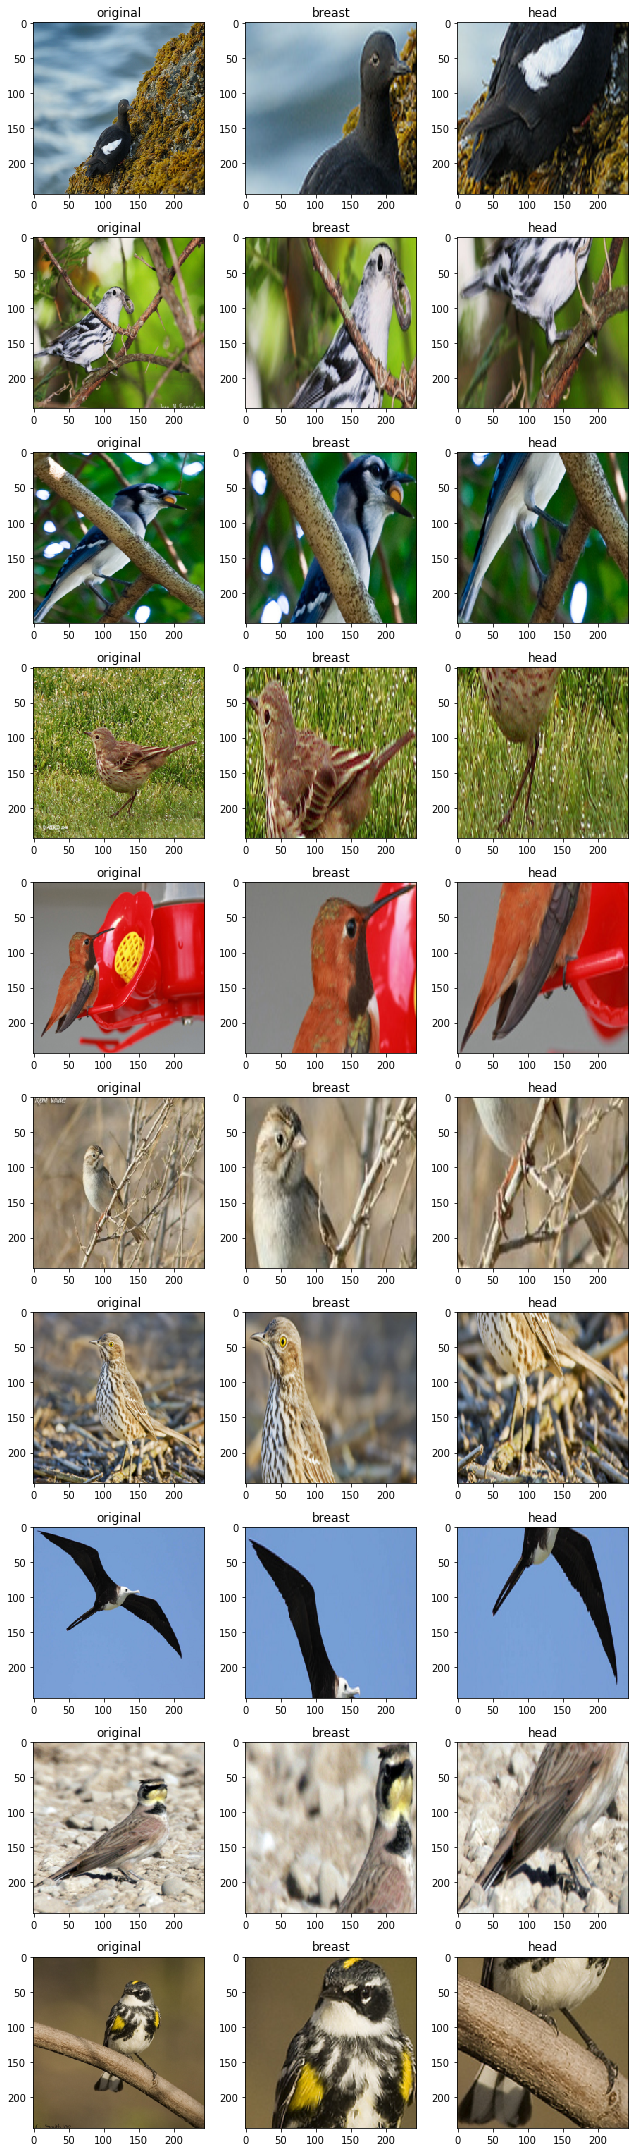

In [13]:
data_generator = FewshotBirdsDataGenerator()
xs, ys = data_generator.sample_episode_batch(data_generator.train_data)
# see what the parts and images look like
f, ax = plt.subplots(data_generator.batch_size, 3, figsize=(3*3, data_generator.batch_size*3))
for i in range(data_generator.batch_size):
    ax[i, 0].imshow(xs[0][i, 0])
    ax[i, 0].set_title('original')
    ax[i, 1].imshow(xs[0][i, 1])
    ax[i, 1].set_title('breast')
    ax[i, 2].imshow(xs[0][i, 2])
    ax[i, 2].set_title('head')
plt.tight_layout()
plt.show()
